In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle

import tensorflow as tf 
import cv2


## Specify GPU device for current work

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Define constants

In [189]:
# Determine constants

labels = ['live', 'spoof']
data_prabhat = r'D:\LivenessDetectionDatasets\antispoofingDataPrabhat'
data_nuaa_detected = r'D:\LivenessDetectionDatasets\NUAA-Detectedface'
data_nuaa_raw = r'D:\LivenessDetectionDatasets\NUAA-raw'
image_width=image_height = 120
n_color_sector = 3
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

## Data Reading from different directories 

In [190]:
def data_converter_from_path(data_paths):
    X= []
    y = []
    
    for data_path in data_paths:
        for label in labels:
            join_label = os.path.join(data_path, label)
            for image_folder in os.listdir(join_label):
                if image_folder[:2]=='00':
                    join_image_folder = os.path.join(join_label, image_folder)
                for image in os.listdir(join_image_folder):
                    join_image = os.path.join(join_image_folder, image)
                    if (join_image[-3:]=='jpg')|(join_image[-3:]=='png'):
                        img = cv2.imread(join_image)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (image_width, image_height))
                        X.append(img)
                        y.append(labels.index(label))
    return X, y

data_paths = [data_nuaa_detected]
X, y = data_converter_from_path(data_paths)  
    
def data_converter_from_simple(data_paths):
    for data_path in data_paths:
        for label in labels:
            join_label = os.path.join(data_path, label)
            for image in os.listdir(join_label):
                join_image = os.path.join(join_label, image)
                if (join_image[-3:]=='jpg')|(join_image[-3:]=='png'):
                    img = cv2.imread(join_image)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (image_width, image_height))
                    X.append(img)
                    y.append(labels.index(label))
    return X, y
    

In [191]:
X = np.array(X)
y = np.array(y)
X, y = shuffle(X,y, random_state=123)

In [192]:
from sklearn.model_selection import train_test_split

print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'Training dataset size of X_train: {len(X_train)}')
print(f'Testing dataset size of X_test: {len(X_test)}')
print(f'Testing dataset size of y_train: {len(y_train)}')
print(f'Testing dataset size of y_test: {len(y_test)}')
# print(f'Testing dataset size of X_test: {len(X_val)}')
# print(f'Testing dataset size of y_train: {len(y_val)}')


(12732, 120, 120, 3)
(12732,)
Training dataset size of X_train: 8912
Testing dataset size of X_test: 3820
Testing dataset size of y_train: 8912
Testing dataset size of y_test: 3820


In [194]:
np.array(X).shape, np.array(y).shape

((12732, 120, 120, 3), (12732,))

In [195]:
(unique, counts) = np.unique(np.array(y), return_counts=True)
for type_s, count in zip(np.array(labels)[unique], counts):
    print(f'There are {count} images in {type_s} directory.')

There are 5223 images in live directory.
There are 7509 images in spoof directory.


## Data visualization

In [196]:
def visualize_images(X,y, amount_of_images, rows, cols):
    list_of_images = random.sample(range(0, len(y)), amount_of_images)
    fig  = plt.figure(figsize =(30,30))
    for i in range(1, rows*cols+1):
        fig.add_subplot(rows, cols, i)
        img_array = X[list_of_images[i-1]]
        plt.imshow(img_array)
        plt.xlabel(labels[y[list_of_images[i-1]]])
    plt.show()
    

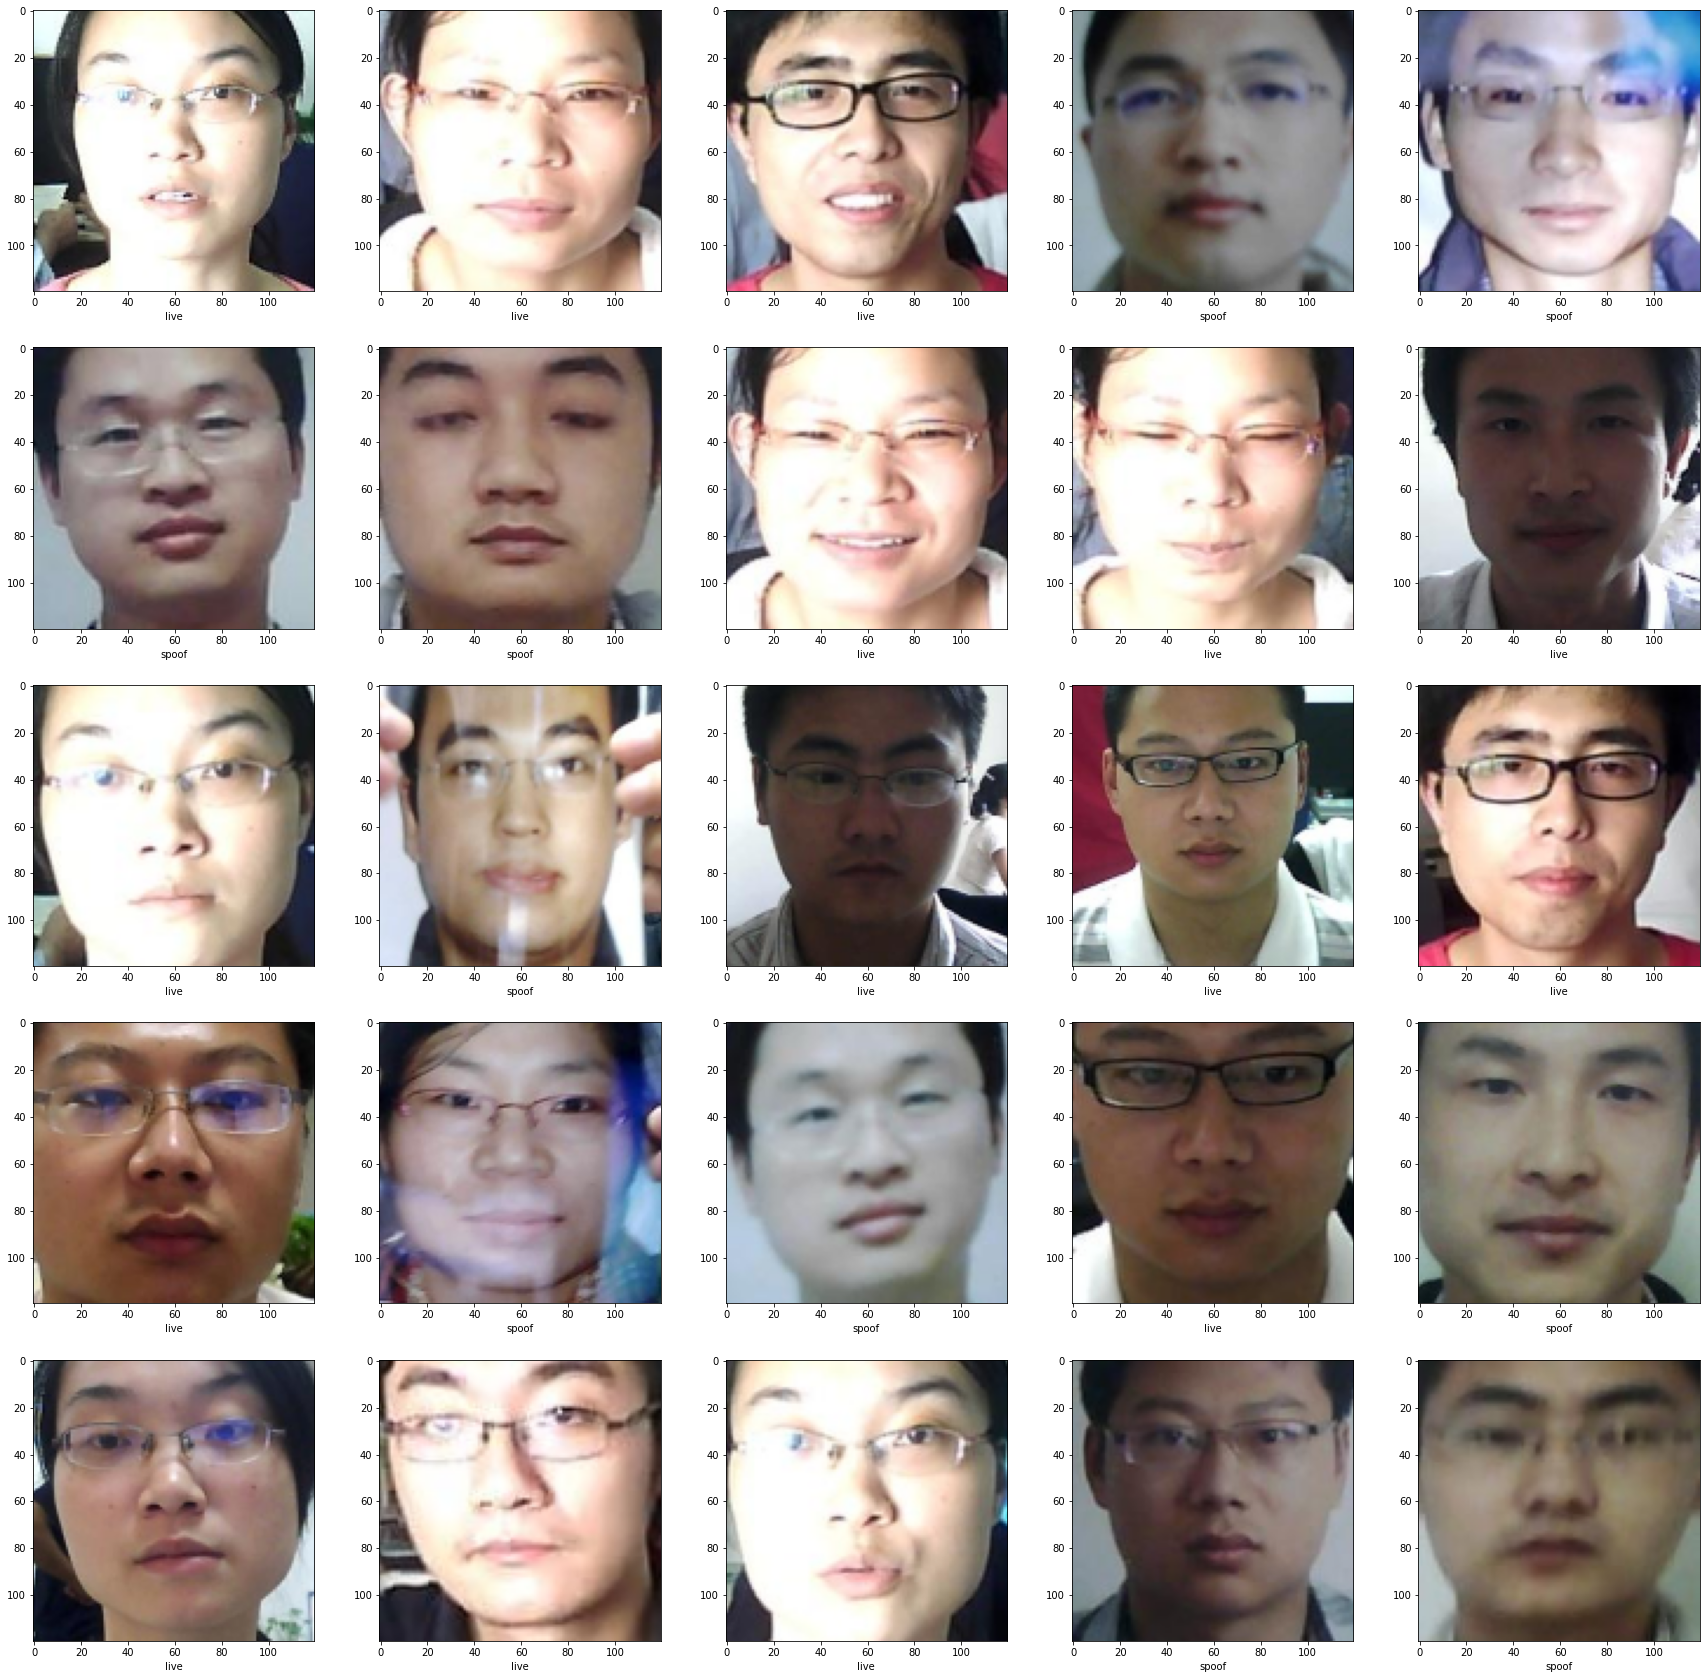

In [197]:
visualize_images(X,y, 25, 5, 5)

## Model Preparation

In [198]:
from tensorflow.keras.layers import *
from tensorflow.keras import layers 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam , RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import KFold, StratifiedKFold
import json
import gc

In [199]:
input_image = Input(shape=(image_height, image_width, n_color_sector))


# A InceptionResNetV2 Conv2D model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_image)

base_model.summary()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

In [200]:
base_model.trainable = False

In [201]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=input_image, outputs=output)

model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

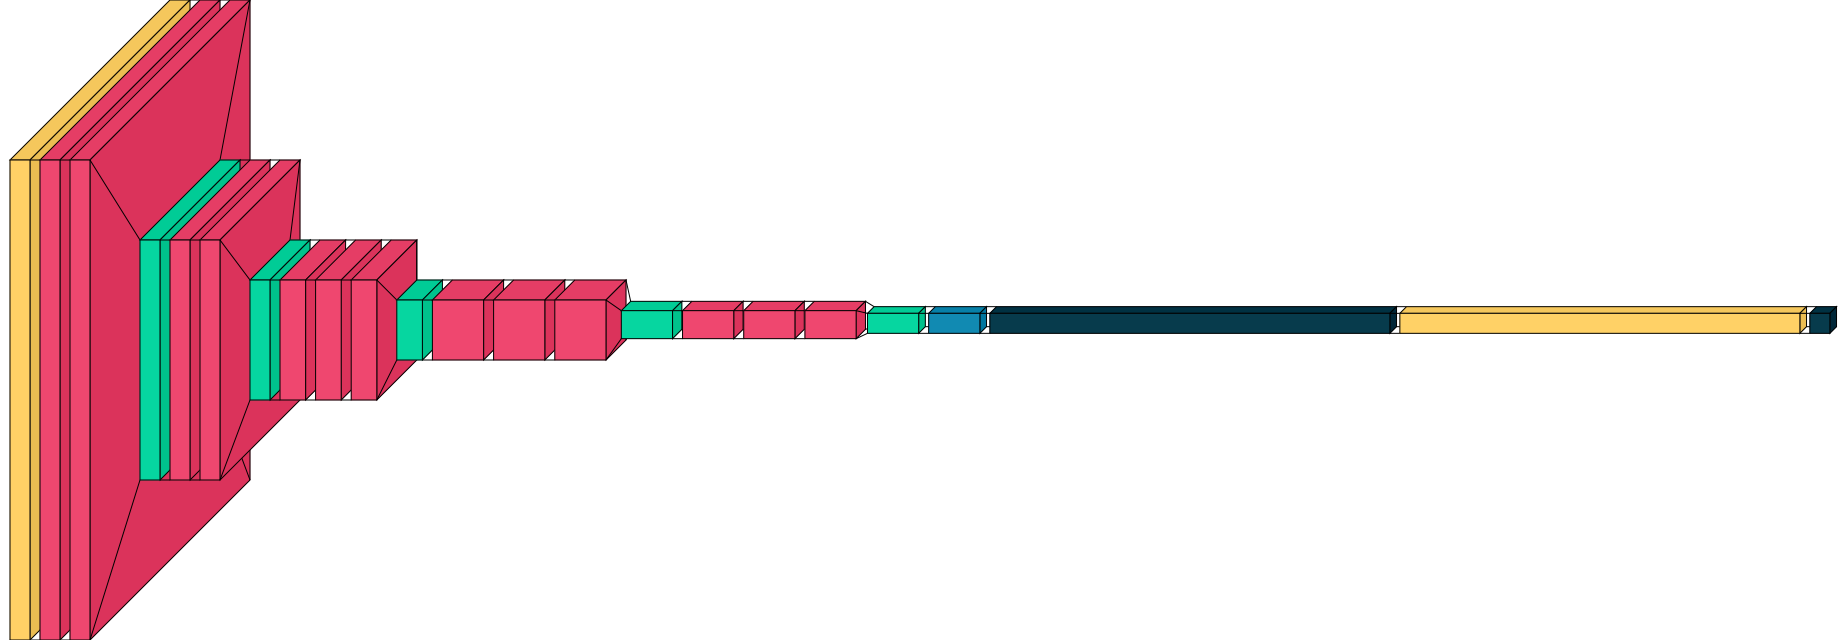

In [202]:
import visualkeras
visualkeras.layered_view(model)

In [203]:
# tell the model what cost and optimization method to use
model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=SGD(learning_rate=0.001),
  metrics=['accuracy']
)

In [204]:
model_checkpoint = ModelCheckpoint('VGG16_antispoofing_model_{epoch:02d}-{val_accuracy:.6f}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True,save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 10, min_delta = 0.001,
                              mode='auto',verbose=1)

In [179]:
epochs=15
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
cvscores = []
historieskv = []
Fold = 1
for train, val in kfold.split(np.array(X_train), y_train):
    gc.collect()
    K.clear_session()
    
    x_train = np.array(X_train)[train]
    x_val = np.array(X_train)[val]
    
    Y_train = y_train[train]
    Y_val = y_train[val]
     
    print("=========================================")
    print("====== K Fold Validation step => %d/%d =======" % (Fold,k))
    print("=========================================")

    historykv=model.fit(x_train, Y_train, 
              validation_data=(x_val, Y_val),
              epochs=epochs,
              batch_size=8,
              callbacks=[model_checkpoint,es], verbose=1)
    historieskv.append(historykv)
    
    
    # evaluate the model
    scores = model.evaluate(x_val, Y_val, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    
    Fold = Fold +1

print("%s: %.2f%%" % ("Mean Accuracy of CV scores: ",np.mean(cvscores)))
print("%s: %.2f%%" % ("Standard Deviation of CV scores: +/-", np.std(cvscores)))

loss_test, acc_test = model.evaluate(X_test, y_test)

print ("\n\n================================\n\n")
print ("Loss on Test Set: {}".format(loss_test))
print ("Accuracy on Test Set: {0:.2f} %".format(acc_test * 100))
print ("\n\n================================\n\n")

====== K Fold Validation step => 1/3 =======
Epoch 1/35
496/496 [==============================] - 103s 197ms/step - loss: 0.6320 - accuracy: 0.8407 - val_loss: 0.0260 - val_accuracy: 0.9912

Epoch 00001: val_loss improved from inf to 0.02604, saving model to VGG16_antispoofing_model_01-0.991249.h5
Epoch 2/35
496/496 [==============================] - 93s 188ms/step - loss: 0.0690 - accuracy: 0.9756 - val_loss: 0.0154 - val_accuracy: 0.9946

Epoch 00002: val_loss improved from 0.02604 to 0.01537, saving model to VGG16_antispoofing_model_02-0.994615.h5
Epoch 3/35
496/496 [==============================] - 94s 189ms/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.0124 - val_accuracy: 0.9956

Epoch 00003: val_loss improved from 0.01537 to 0.01240, saving model to VGG16_antispoofing_model_03-0.995624.h5
Epoch 4/35
496/496 [==============================] - 94s 189ms/step - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.0111 - val_accuracy: 0.9963

Epoch 00004: val_loss improved from 0.

In [180]:
# serialize model to JSON
model_json = model.to_json()
with open("fantispoofing_model_VGG16.json", "w") as json_file:
    json_file.write(model_json)

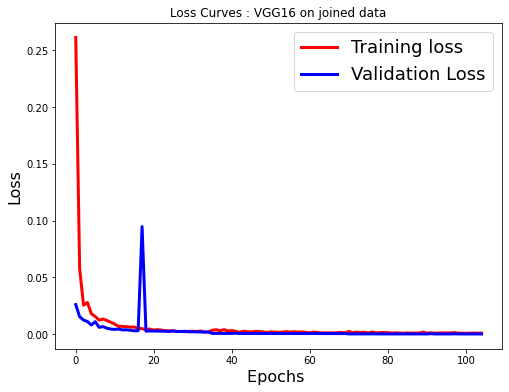

In [181]:
fig1 = plt.figure(figsize = (8,6))
plt.plot([j for i in historieskv for j in i.history['loss']],'r',linewidth=3.0)
plt.plot([j for i in historieskv for j in i.history['val_loss']],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title(f'Loss Curves : VGG16 on joined data',fontsize=12)
plt.show()

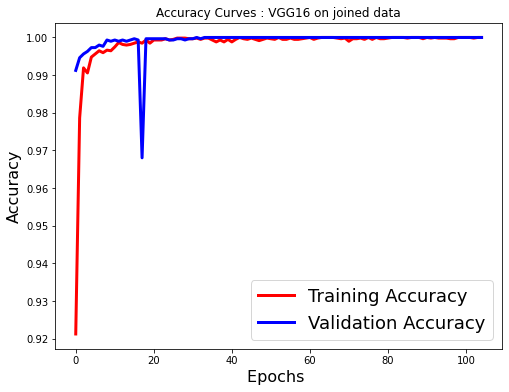

In [182]:
fig2=plt.figure(figsize = (8,6))
plt.plot([j for i in historieskv for j in i.history['accuracy']],'r',linewidth=3.0)
plt.plot([j for i in historieskv for j in i.history['val_accuracy']],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title(f'Accuracy Curves : VGG16 on joined data',fontsize=12)
plt.show()

In [183]:
pred = model.predict(X_test)
y_pred =np.argmax(pred, axis=1)
print(pred)

[[9.99997854e-01 2.09736777e-06]
 [2.83135222e-07 9.99999762e-01]
 [1.11386335e-05 9.99988914e-01]
 ...
 [1.20177077e-07 9.99999881e-01]
 [2.21223422e-06 9.99997735e-01]
 [9.99984860e-01 1.51246895e-05]]


In [184]:
y_pred

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [185]:
y_test

array([0, 1, 1, ..., 1, 1, 0])

In [186]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

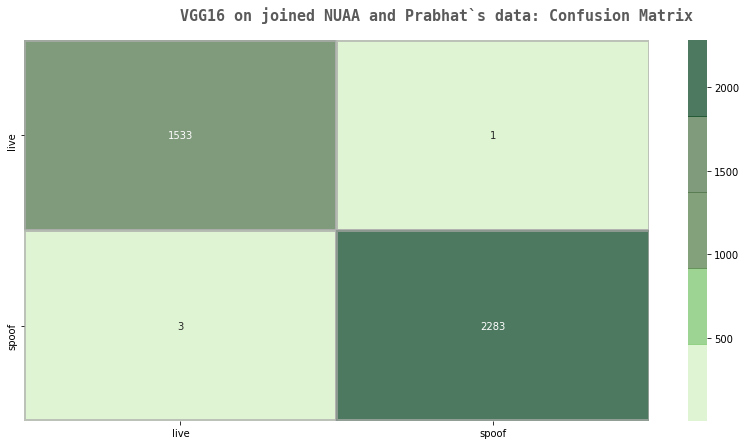

In [187]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,fmt='g',
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='VGG16 on joined NUAA and Prabhat`s data: Confusion Matrix',size=15,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [188]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1534
           1       1.00      1.00      1.00      2286

    accuracy                           1.00      3820
   macro avg       1.00      1.00      1.00      3820
weighted avg       1.00      1.00      1.00      3820

